In [29]:
from matplotlib import pyplot as plt
import seaborn as sb
import pandas as pd
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc
from imblearn.over_sampling import SMOTE
from sklearnex import patch_sklearn
from daal4py.oneapi import sycl_context
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## 02. 데이터 가져오기

In [2]:
origin = pd.read_excel("https://data.hossam.kr/G02/breast_cancer.xlsx")

## 03. 데이터 전처리

### 독립/종속 변수 분리

In [3]:
origin['target'].value_counts()


target
1    357
0    212
Name: count, dtype: int64

In [4]:
x = origin.drop(['target'], axis = 1)
y = origin['target']
x.shape, y.shape

((569, 30), (569,))

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x,y, random_state=1111)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((426, 30), (426,), (143, 30), (143,))

In [9]:
smote_sampler = SMOTE( sampling_strategy="minority", random_state=111)
x_sm, y_sm = smote_sampler.fit_resample(x_train,y_train)
print(x_sm.shape, y_sm.shape)

y_sm.value_counts().sort_index()

(540, 30) (540,)


target
0    270
1    270
Name: count, dtype: int64

## 04. 훈련 모델 적합

### 단일 모델 

#### 부스팅에 사용할 학습 알고리즘 생성

In [11]:
dt =  DecisionTreeClassifier(max_depth = 2, min_samples_leaf=10, random_state= 111)
dt

DecisionTreeClassifier(max_depth=2, min_samples_leaf=10, random_state=111)

#### AdaBoost 생성

In [13]:
ada = AdaBoostClassifier(
    base_estimator=dt,
    n_estimators=100,
    random_state=111)

ada.fit(x_sm, y_sm)

print("훈련 정확도: ", ada.score(x_sm, y_sm))

y_pred = ada.predict(x_test)
print('테스트 정확도 :', accuracy_score(y_test, y_pred))

c:\Users\yis82\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


훈련 정확도:  1.0
테스트 정확도 : 0.986013986013986


### 분류 보고서

In [24]:
print(classification_report(y_test,  y_pred))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98        56
           1       0.98      1.00      0.99        87

    accuracy                           0.99       143
   macro avg       0.99      0.98      0.99       143
weighted avg       0.99      0.99      0.99       143



In [15]:
score1 = ada.predict_proba(x_test)[:, 1]
score1[:5]

array([0.80548229, 0.94757069, 0.96266912, 0.87461649, 0.30954945])

#### ROC 구하기

실제 Label과 Positive Label에 대한 예측 확률을 전달하여 roc 곡선 표현에 필요한 값들을 리턴받는다.

- 첫 번째 리턴값 : False Positive Rate (민감도)
- 두 번째 리턴값 : True Positive Return (재현율)
- 세 번째 리턴값 : 절단값(ROC 커브 구현에 사용되지 않음)

In [19]:
fpr1, tpr1, cut1 = roc_curve(y_test, score1)

#### ROC 곡선 시각화

가운데 직선에 가까울수록 분류 성능이 떨어지는 것이다.

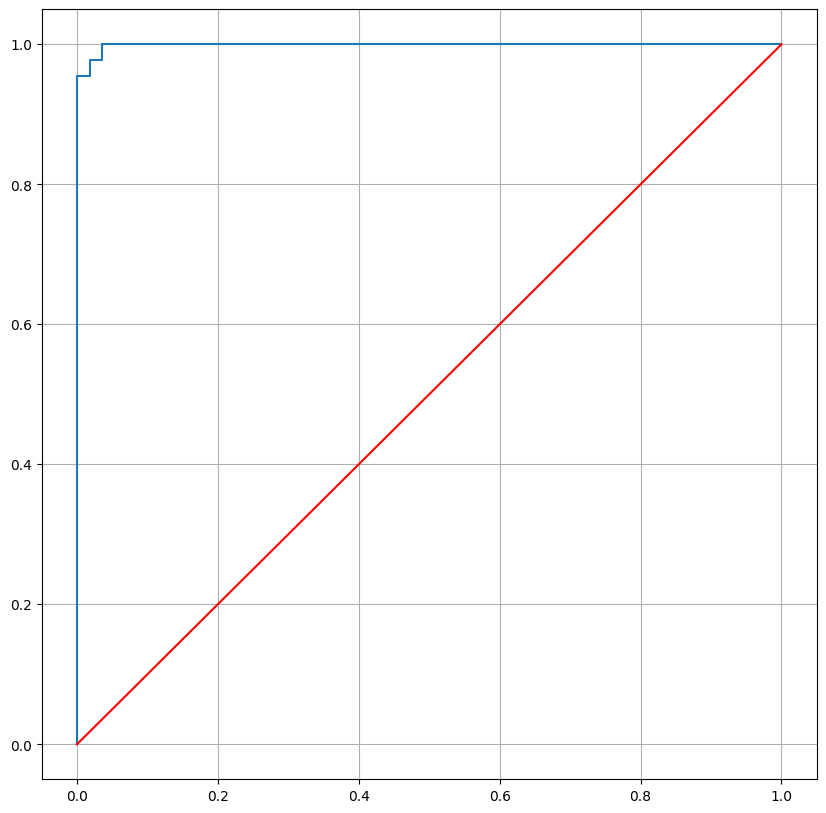

In [23]:
plt.figure(figsize= (10,10))
plt.plot(fpr1, tpr1)
plt.plot([0,1], [0,1], color = 'red')
plt.grid()
plt.show()

### AUC 값 직접 계산하기

#### 실제 Label과 Positive의 예측확률로 계산

In [31]:
print("roc_auc_score 함수 결과: ", roc_auc_score(y_test,score1))

roc_auc_score 함수 결과:  0.9987684729064039


#### False Positive Rate와 True Positive Rate로 계산

In [30]:
print("auc 함수 결과: ", auc(fpr1, tpr1))

auc 함수 결과:  0.9987684729064039
